# Session 9 Part 3: Time dependent PDEs

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab

In [5]:
from scipy import sparse
import scipy.sparse.linalg as linalg   # linear algebra for sparse systems

def createSecondOrderDiffMatrix_d2y_dx2(N, h):
    M_SecondOrderTerm = ( -2*sparse.eye(N,N,0) + sparse.eye(N,N,1) + sparse.eye(N,N,-1) ) / h**2
    return M_SecondOrderTerm
    
def createFirstOrderDiffMatrix_dy_dx(N, h):
    M_FirstOrderTerm = ( sparse.eye(N,N,1) - sparse.eye(N,N,-1) ) / (2*h)
    return M_FirstOrderTerm
    
def returnDiagonalMatrixFor_y(N):
    M_forY = sparse.eye(N,N,0)
    return M_forY

---

# 5 Time dependent 1D PDEs: Timestepping

## 5.1 Your first PDE: Time dependent Diffusion in 1D

The example you see here is called the Method of Lines

We now have evolution in 1D space and time.

$$\frac{dy}{dt}=D \frac{d^2y}{dx^2} $$

We will diffuse a step function in, for example, temperature away.

Text(0.5,0,'x')

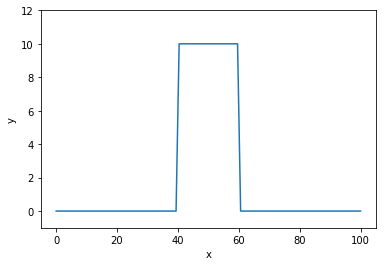

In [2]:
## Initial step function which we will diffuse away below...

N=100      # Specify number of nodes

x = np.linspace(0,100,N)     # Discretise 1D spatial domain
h = x[1]-x[0]                # calculate the spatial stepsize

## Create an initial distribution which is a tophat function
y=np.zeros(N)
y[40:60]=10

plt.plot(x,y)
plt.ylim(-1,12)
plt.ylabel("y")
plt.xlabel("x")

__NOTATION:__ We will used subscripts and superscripts to denote:  $y_{space}^{time}$

- The discretisaion of the RHS in space at time $t=n$ is:

 $$D \frac{d^2y}{dx^2} \approx D \frac{y_{i+1}^n-2y_{i}^n+y_{i-1}^n}{h^2}$$
 
- The discretisation of the LHS in time is:

$$\frac{dy}{dt} \approx \frac{y_{i}^{n+1} - y_{i}^n}{\delta t}$$

- Putting these together:

$$\frac{y_{i}^{n+1} - y_{i}^n}{\delta t} = D \frac{y_{i+1}^n-2y_{i}^n+y_{i-1}^n}{h^2}$$

Which we can rearrange for $y$ at the next timestep, $y_{i}^{n+1}$:

$$y_{i}^{n+1} = y_{i}^n + \delta t \, D \frac{  y_{i+1}^n-2y_{i}^n+y_{i-1}^n }{h^2}$$

By inspection, you can see that the estimate of $y_i^{n+1}$ is expressed as a function of the the current value of $y$ and the current values at the adjacent nodes i.e. $y_{i-1}^{n}$, $y_i^{n}$ and $y_{i+1}^{n}$.

This can be written as a matrix equations where:

$$\mathbf{y_{n+1}} = \mathbf{M.y_n}$$

Where: 

- $\mathbf{y_n}$ are all the current values of $y$.
- $\mathbf{y_{n+1}}$ are all the new values of $y$.
- $\mathbf{M}$ is the matrix that combines together all the terms from the discretised diffusion equation above.

Let's look at what needs to go into $\mathbf{M}$ in a bit more detail.

 $$y_{i}^n + \delta t \, D \frac{  y_{i+1}^n-2y_{i}^n+y_{i-1}^n }{h^2}$$

- The first term is a term which is just the current value of $y$ which we include using an identify matrix
- The second term is the matrix describing the second derivative, multiplied by the timestep and the diffusion constant.

Let's implement this below

Text(0.5,0,'x')

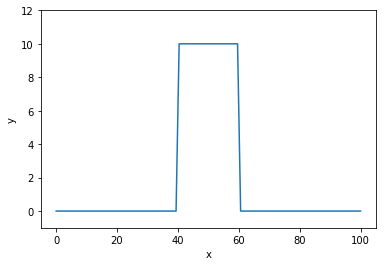

In [3]:
## Initial step function which we will diffuse away below...
N=100      # Specify number of nodes

x = np.linspace(0,100,N)     # Discretise 1D spatial domain
h = x[1]-x[0]                # calculate the spatial stepsize

## Create an initial distribution which is a tophat function
y=np.zeros(N)
y[40:60]=10

plt.plot(x,y)
plt.ylim(-1,12)
plt.ylabel("y")
plt.xlabel("x")

KeyboardInterrupt: 

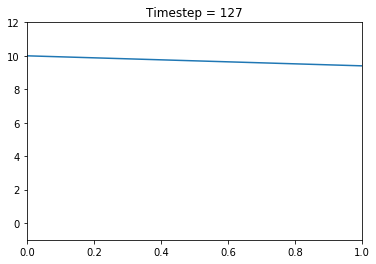

In [9]:
import time
from IPython import display

## Set diffusion parameters:
dt = 0.1   # Define timestep
D = 2      # Define diffusion constant

## Create the update matrix
M = dt*D* createSecondOrderDiffMatrix_d2y_dx2(N, h) + returnDiagonalMatrixFor_y( N )

## Loop over 200 timesteps
for i in range(200):
    
    # Calculate the new y by dotting the old y with the matrix M
    y = M.dot(y) 
    
    # Plot the result
    plt.plot(x,y, hold=False)
    plt.axvline(x=x[40], color='green', linestyle="--")
    plt.axvline(x=x[60], color='green', linestyle="--")
    plt.ylim(-1,12)
    plt.ylabel("y")
    plt.xlabel("x")
    plt.title("Timestep = "+str(i))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.05) # necessary to get the plot up.

**QUESTION: How would I modify the code above to hold the LHS at 10 degrees?**
- Implement this and look what happens

## 5.2 von Neumann Stability analysis of the Diffusion Equation in 1D [ADVANCED]

Let's start with the diffusion equation and assume that the diffusivity, $D$ is constant.

$$\frac{\partial u}{\partial t} = D \nabla^2 u$$

Which in 1D discretises to,

$$\frac{u_{j}^{n+1}-u_{j}^{n}}{\delta t} = D \left[ \frac{u_{j+1}^{n}-2u_{j}^{n} + u_{j-1}^{n}}{h^2} \right] $$

We need to be careful with notation here. For this 1D case, we are now using $u_j^n$ to indicate the value of $u$ at $x= j \times h$ and $t=n \times \delta t$. This is not saying we are raising $u$ to the power $n$.

This rearranges to,

$$u_{j}^{n+1} = u_{j}^{n} + \frac{D \delta t}{h^2} \left[ u_{j+1}^{n}-2u_{j}^{n} + u_{j-1}^{n} \right] $$

Basically, we need $$\frac{D \delta t}{h^2}$$ to be sufficiently small that the updates are small!

The formal analysis below boils down to showing that:
$$\frac{D \delta t}{h^2} \le \frac{1}{2}$$

The method below shows you how to calculate this formally...

---

** Aside: von Neumann stability analysis [ADVANCED]**

To analyse the stability of a finite difference scheme, we can use the von Neumann stability analysis which locally linearises the equations (if they are non-linear) and then looks for growth in the linear modes. If any modes grow - it is unstable

We can use a trial solution with complex exponential to **describe oscillations in space** and an **exponential term for the time dependance**:

$$u_{j,n}=A(k)^n e^{\imath kj}$$

In order to discriminate the imaginary $\imath = \sqrt{-1}$ from the incides $i$ we use $\imath$ which has no dot to represent the imaginary number.

Plugging this Ansatz into the finite difference equation, we can solve for $A(k)$. The equation is unstable if $|A(k)|>1$ for some $k$.

---


$$u_{j}^{n+1} = u_{j}^{n} + \frac{D \delta t}{h^2} \left[ u_{j+1}^{n}-2u_{j}^{n} + u_{j-1}^{n} \right] $$
Substituting  the von Neumann ansatz into the discretised diffusion equation, we get:

$$A^{n+1} e^{\imath kj} = A^{n} e^{\imath kj} - \frac{D \delta t}{h^2} \left( A^{n} e^{\imath k(j+1)} - 2 A^{n} e^{\imath kj} + A^{n} e^{\imath k(j-1)} \right)$$

Dividing through by $A^n e^{\imath kj}$,

$$A = 1 - \frac{D \delta t}{h^2} \left(  e^{\imath k} - 2 + e^{-\imath k} \right)$$

And converting the complex exponentials to trig functions,


$$A = 1 - \frac{D \delta t}{h^2} \left(  2 \cos k -2 \right)
= 1 - 4 \frac{D \delta t}{h^2} \sin^2\frac{k}{2}$$

So, to ensure stability, $|A| \le 1$,

$$4 \frac{D \delta t}{h^2} \le 2 \quad \Rightarrow  \quad  \frac{2 D \delta t}{h^2} \le 1 $$

This gives a constraint on the timestep of,

$$\delta t \le \frac{h^2}{2 D}$$

In [13]:
dt = 0.3   # Define timestep
D = 2      # Define diffusion constant

h = 1                # Specify the spatial stepsize
x = np.arange(0,100,h)     # Discretise 1D spatial domain


## Create an initial distribution which is a tophat function
y=np.zeros_like(x)
y[40:60]=10

# Create the update matrix
M = dt*D* createSecondOrderDiffMatrix_d2y_dx2(N, h) + returnDiagonalMatrixFor_y( N )

print("dt ", dt)
print("h^2/2D = ", h**2/(2*D))
if(dt<h**2/(2*D)):
    print("Should be stable")
else:
    print("Solution is unstable")

dt  0.3
h^2/2D =  0.25
Solution is unstable


KeyboardInterrupt: 

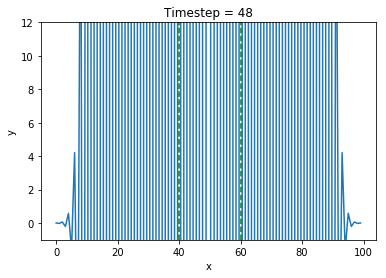

In [15]:
import time
from IPython import display

# Loop over 200 timesteps
for i in range(200):
    
    # Calculate the new y by dotting the old y with the matrix M
    y = M.dot(y) 
    
    # Plot the result
    plt.plot(x,y, hold=False)
    plt.axvline(x=x[40], color='green', linestyle="--")
    plt.axvline(x=x[60], color='green', linestyle="--")
    plt.ylim(-1,12)
    plt.ylabel("y")
    plt.xlabel("x")
    plt.title("Timestep = "+str(i))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.005) # necessary to get the plot up.

## 5.3 The wave equation in 1D

In general, the wave equation is written:

$$ \frac{\partial^2 \mathbf{u}}{\partial t}=c^2 \nabla^2 \mathbf{u}$$

which we can write in 1D as:

$$ \frac{\partial^2 \mathbf{u}(x,t)}{\partial t}=c^2 \frac{\partial^2 \mathbf{u}(x,t)}{\partial x^2} $$

Discretising both sides gives:

$$ \frac{  y_{i}^{n-1}-2y_{i}^n+y_{i}^{n+1} }{\delta t^2} = c^2 \frac{  y_{i+1}^n-2y_{i}^n+y_{i-1}^n }{h^2}$$

Rearrange this to get $y_{i}^{n+1}$ on the LHS.

Which we can rearrange to:

$$  y_{i}^{n+1}  = 2y_{i}^n - y_{i}^{n-1} + \delta t^2 \, c^2 \frac{  y_{i+1}^n-2y_{i}^n+y_{i-1}^n }{h^2}$$

This is similar in many ways to the discretised diffusion equation for the first and last terms on the RHS.

However, the estimate of the new $y$ is not just dependent on the current value BUT ALSO the previous!

Below we create a matrix to deal with: $$2y_{i}^n + \delta t^2 \, c^2 \frac{  y_{i+1}^n-2y_{i}^n+y_{i-1}^n }{h^2}$$

In [17]:
dt = 0.1   # Define timestep
c = 0.1      # Define diffusion constant

h = 0.01                # Specify the spatial stepsize
x = np.arange(0,1.5,h)     # Discretise 1D spatial domain

N = len(x)
## Create an initial distribution which is a tophat function
y=np.zeros_like(x)

previousY = y

# Create the update matrix
M = dt**2 * c**2 * createSecondOrderDiffMatrix_d2y_dx2(N, h) + 2* returnDiagonalMatrixFor_y( N )

print(dt**2 * c**2/ h**2)

1.0000000000000004


We keep track of the term $$- y_{i}^{n-1}$$ inside the time loop using `currentY`.

**QUESTIONS:**
- What forcing have I applied at the LHS?
- What BC have I applied at the RHS?

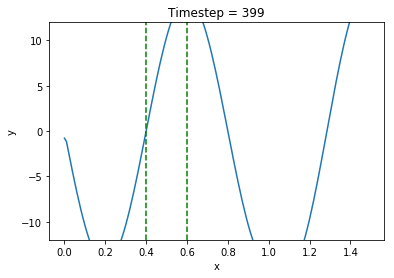

In [18]:
# Loop over 200 timesteps
for i in range(400):
    currentY = y
    # Calculate the new y by dotting the old y with the matrix M
    y[0] = 10* np.sin(i*np.pi/40)
    y[-1] = y[-2] 
    
    y = M.dot(y) - previousY
    y[0] = 10* np.sin(i*np.pi/40)
    y[-1] = y[-2] 
    
    previousY = currentY
    
    # Plot the result
    plt.plot(x,y, hold=False)
    plt.axvline(x=x[40], color='green', linestyle="--")
    plt.axvline(x=x[60], color='green', linestyle="--")
    plt.ylim(-12,12)
    plt.ylabel("y")
    plt.xlabel("x")
    plt.title("Timestep = "+str(i))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.05) # necessary to get the plot up.

## EXERCISE: How would you tackle the problems below computationally?

The questions below are all taken from the Math part of this course. I want you to communiacte how you would tackle these questions but using a computational approach.

$$ \frac{\partial T}{\partial t}= \kappa \nabla^2T$$

8.3 The ends of a metal rod with thermal diffusivity $\kappa$ are at $x = 0$ and $x = L$, and are held at a fixed temperature $T_0$. At time $t = 0$ the temperature $T(x, t)$ of the rod is given by $T(x, 0) = T_0 + T_1 \sin \frac{\pi n x}{L}$, where $n$ is an integer. How does the temperature of the rod evolve? If the hottest part of the rod is at temperature $T_m(t)$, how long does it take for $T_m - T_0$ to decrease by a factor $e$ if

(a) $n = 1$

(b) $n = 2$

9.1 Calculate the skin depths for the penetration of periodic daily and annual
temperature variations into the Earth. Assume the thermal diffusivity has a value of $10^6$ $m^2s^{-1}$.

9.2 Assume that the temperature change associated with glaciations can be treated as a
sinusoidal variation with period 10,000 years. Calculate the skin depth $\delta$ for the penetration of the temperature wave into the Earth, assuming $\kappa = 10^6 m^2s^{-1}$. A
borehole is to be drilled in order to measure the terrestrial heat flow into its base.
How deep must the hole be to reduce the temperature variations associated with the
glaciations to 1% of their surface value?

9.3 Calculate the temperature gradient produced at depth $Z$ in the earth by a periodic
surface temperature variation of amplitude $\Delta T$ and frequency $\omega$. Compare its
maximum value at $Z = 100$ m with the normal geothermal gradient, if the period of
the temperature variations is 10,000 years, and the amplitude at the surface is
$10^\circ C$. Assume reasonable values for other parameters.